## Adapted from:

*Python Machine Learning 3rd Edition* by [Sebastian Raschka](https://sebastianraschka.com), Packt Publishing Ltd. 2019

Code Repository: https://github.com/rasbt/python-machine-learning-book-3rd-edition

Code License: [MIT License](https://github.com/rasbt/python-machine-learning-book-2nd-edition/blob/master/LICENSE.txt)

# Homework 3 - INFO 5604

## Josh Gregory

# k Nearet Neighbor (kNN)

In [1]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
import copy
sns.set() 

In [2]:
from IPython.display import Image
%matplotlib inline

# Image(filename='images/03_23.png', width=500) 

In [3]:
# define plot_decision_regions for later use

In [4]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# To check recent matplotlib compatibility
import matplotlib
from distutils.version import LooseVersion


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    color=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        
        if LooseVersion(matplotlib.__version__) < LooseVersion('0.3.4'):
            plt.scatter(X_test[:, 0],
                        X_test[:, 1],
                        c='',
                        edgecolor='black',
                        alpha=1.0,
                        linewidth=1,
                        marker='o',
                        s=100, 
                        label='test set')
        else:
            plt.scatter(X_test[:, 0],
                        X_test[:, 1],
                        c='none',
                        edgecolor='black',
                        alpha=1.0,
                        linewidth=1,
                        marker='o',
                        s=100, 
                        label='test set')        

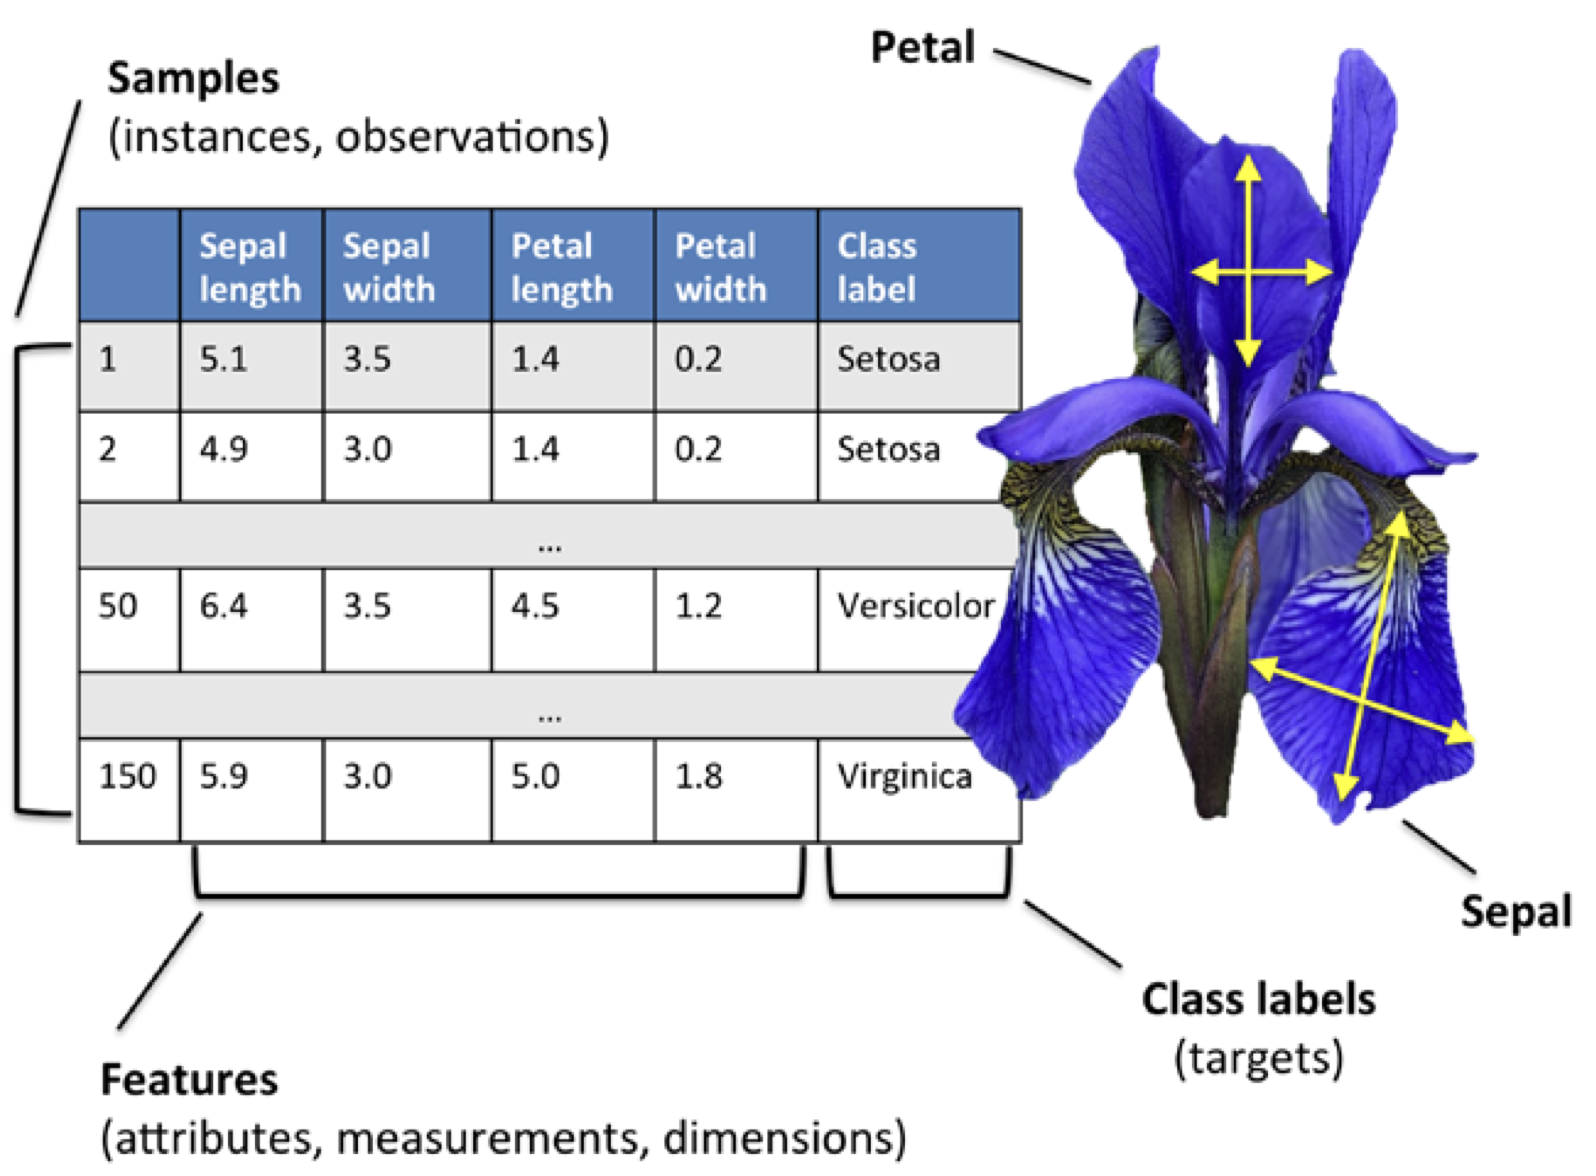

# Load the Cancer dataset

In [5]:
import numpy as np
import pandas as pd

s = 'cancer.csv'

cancer = pd.read_csv(s)
cancer

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883
...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016


## Perform Exploratory Data Analysis according to ICHW 1


### Find the different classes, number of classes, and the number of samples within each class from ICHW1/HW1

In [6]:
classes = pd.unique(cancer['diagnosis'])
num_classes = len(classes)
each_class = cancer['diagnosis'].value_counts()

print(classes)
print(num_classes)
print(each_class)

print(cancer.info())

['M' 'B']
2
B    357
M    212
Name: diagnosis, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      569 non-null    int64  
 1   diagnosis               569 non-null    object 
 2   radius_mean             569 non-null    float64
 3   texture_mean            569 non-null    float64
 4   perimeter_mean          569 non-null    float64
 5   area_mean               569 non-null    float64
 6   smoothness_mean         569 non-null    float64
 7   compactness_mean        569 non-null    float64
 8   concavity_mean          569 non-null    float64
 9   concave points_mean     569 non-null    float64
 10  symmetry_mean           569 non-null    float64
 11  fractal_dimension_mean  569 non-null    float64
dtypes: float64(10), int64(1), object(1)
memory usage: 53.5+ KB
None


**What are the names of the features?**
`radius_mean`, `texture_mean`, `perimeter_mean`, `area_mean`, `smoothness_mean`, `compactness_mean`, `concavity_mean`, `concave points_mean`, `symetry_mean`, and `fractal_dimension_mean`.

**What are the types of features?**
All of the features are continuous.

**How many samples do we have?**
There are 570 samples (0-indexed, so 569+1 = 670 total samples from the dataset output)
    
**How many features do we have?**
We have ten features total

**What are the classes?**
We're told from the Canvas assignment sheet that the target is the second column, which I'm assuming is the diagnosis. We have two classes, `B` for a benign tumor, and `M` for a malignant tumor.

**How many classes do we have?**
Two, see above for more details.
    
    
**How many samples of each class? are they balanced?**
Benign: 357
Malignant: 212

Because some classes have more than others (more Benign samples than Malignant), these classes are not balanced.

### Check missing values, outliers, and statistics

In [7]:
cancer.isna().apply(pd.value_counts)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
False,569,569,569,569,569,569,569,569,569,569,569,569


**Are there any missing values?**
No. Since the previous line returned `False`, there are no values that are missing. Therefore, nothing needs to be done to get rid of outliers.

**Are there outliers?**
Yes, in the boxplots below, we can see that there are outliers in every dataset. I'll set any values that are outliers to be the 75th percentile.

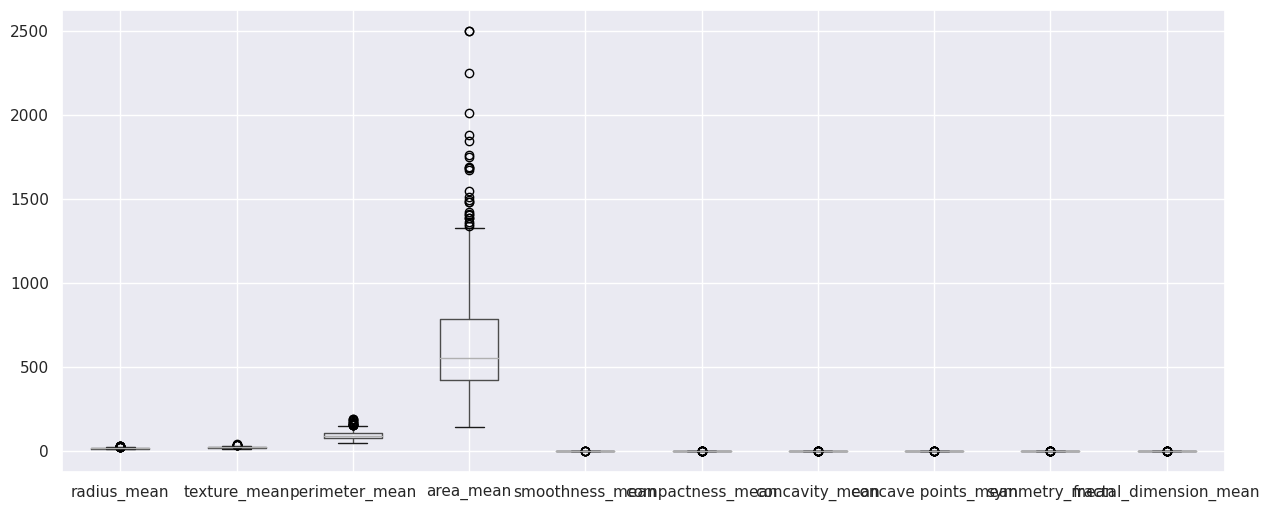

,count,mean,std,min,25%,50%,75%,max
id,569.0,3.037183e+07,1.250206e+08,8670.00000,869218.00000,906024.00000,8.813129e+06,9.113205e+08
radius_mean,569.0,1.412729e+01,3.524049e+00,6.98100,11.70000,13.37000,1.578000e+01,2.811000e+01
texture_mean,569.0,1.928965e+01,4.301036e+00,9.71000,16.17000,18.84000,2.180000e+01,3.928000e+01
perimeter_mean,569.0,9.196903e+01,2.429898e+01,43.79000,75.17000,86.24000,1.041000e+02,1.885000e+02
area_mean,569.0,6.548891e+02,3.519141e+02,143.50000,420.30000,551.10000,7.827000e+02,2.501000e+03
smoothness_mean,569.0,9.636028e-02,1.406413e-02,0.05263,0.08637,0.09587,1.053000e-01,1.634000e-01
compactness_mean,569.0,1.043410e-01,5.281276e-02,0.01938,0.06492,0.09263,1.304000e-01,3.454000e-01
concavity_mean,569.0,8.879932e-02,7.971981e-02,0.00000,0.02956,0.06154,1.307000e-01,4.268000e-01
concave points_mean,569.0,4.891915e-02,3.880284e-02,0.00000,0.02031,0.03350,7.400000e-02,2.012000e-01
symmetry_mean,569.0,1.811619e-01,2.741428e-02,0.10600,0.16190,0.17920,1.957000e-01,3.040000e-01


In [8]:
# Make a bocplot of every column except for the ID number and the diagnosis since those
# don't make sense to include in a boxplot.
cancer.iloc[:, 2:].boxplot(figsize = (15,6))
plt.show()
cancer.describe().T

`area_mean` is taking up a lot of space, so I'm going to make another boxplot without `area_mean` to try and get a better picture of the spread of the other features:

<AxesSubplot: >

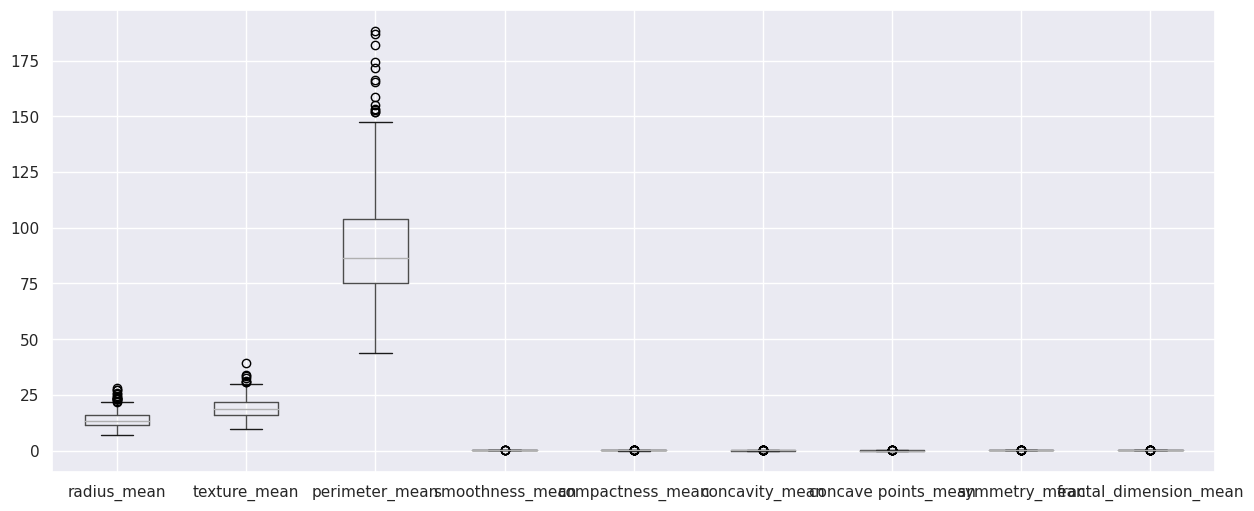

In [9]:
df_filtered = cancer.drop(cancer.columns[[0, 1, 5]], axis=1)
df_filtered.boxplot(figsize = (15,6))

Changes to make to the dataset:

1. Change the "Diagnosis" column to the following:
"B": 0
"M": 1

2. Find the outliers in the other columns and set them equal to the 25th or 75th percentiles

In [10]:
# Implementing step 1
diag_dict = {"B": 0, "M": 1}
cancer['diagnosis'] = cancer['diagnosis'].replace(diag_dict)


# Implementing step 2
for col in cancer.columns[2:]:
    # Calculate the 75th percentile
    threshold_high = cancer[col].quantile(0.75)
    # Set values above the threshold to the threshold value
    cancer[col] = cancer[col].where(cancer[col] <= threshold_high, threshold_high)
    
    # Calculate the 25th percentile
    threshold_low = cancer[col].quantile(0.25)
    # Set values below the threshold to the threshold value
    cancer[col] = cancer[col].where(cancer[col] >= threshold_low, threshold_low)

### Check distributions and correlations

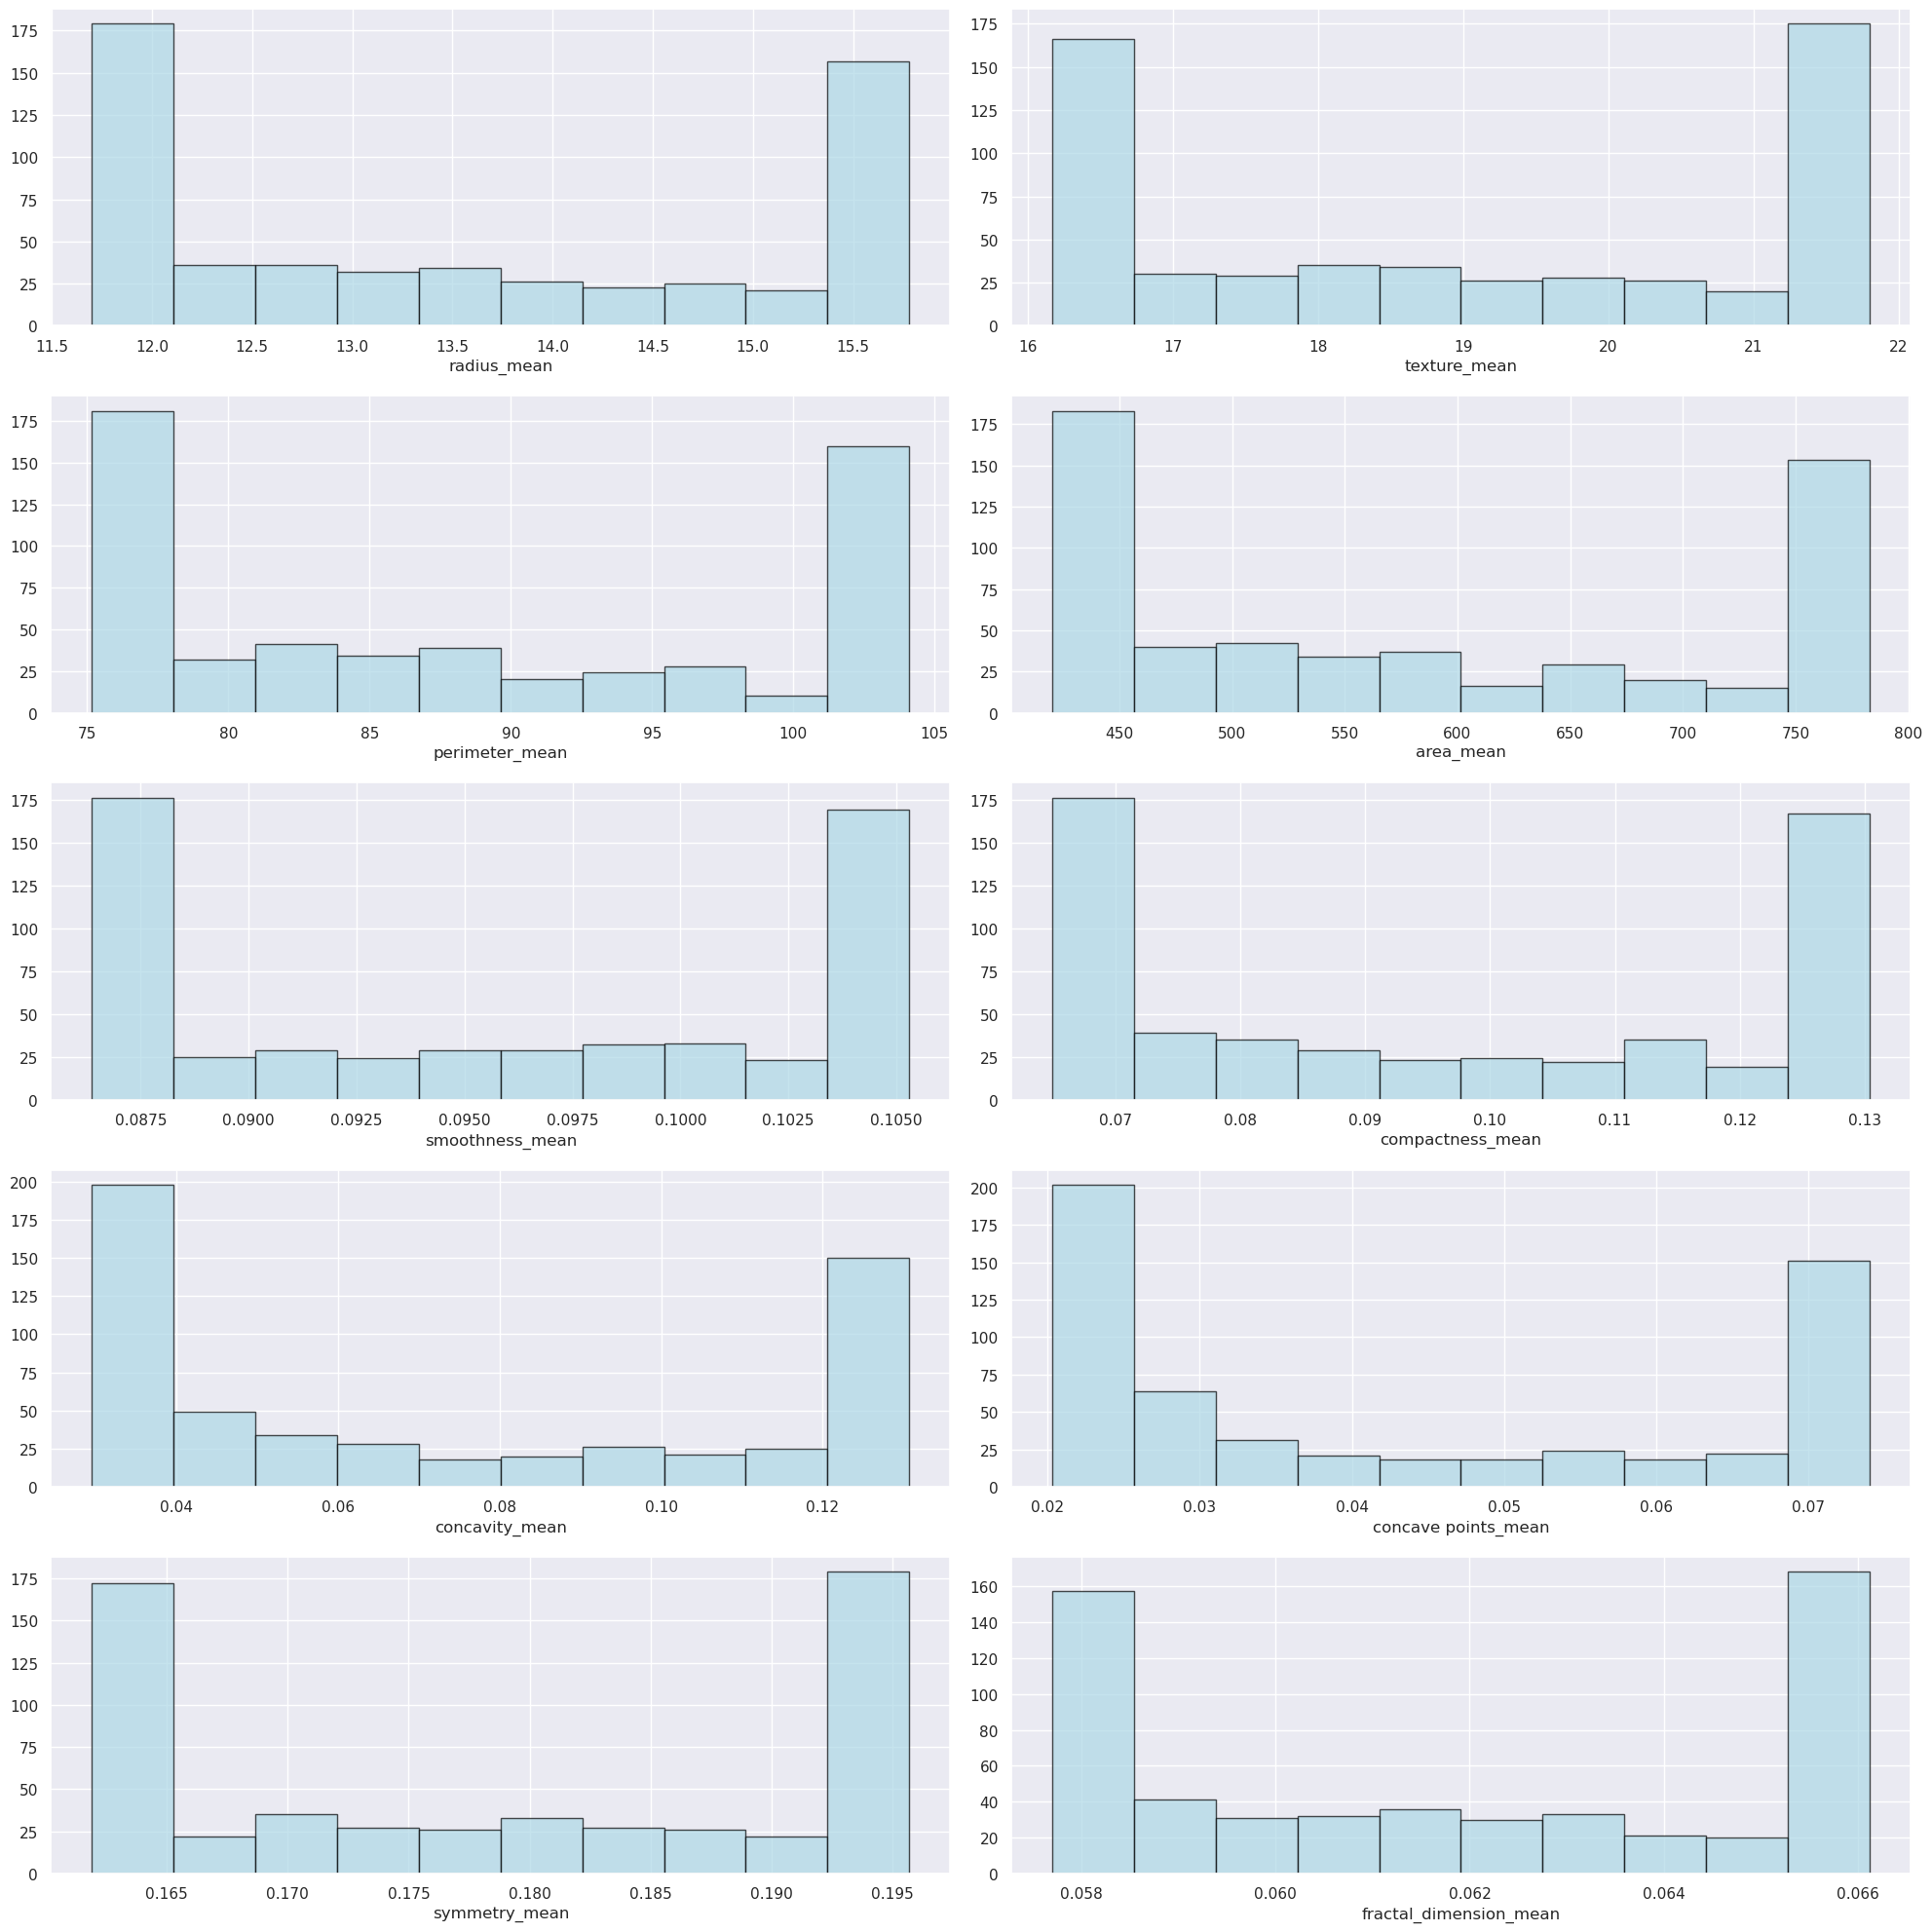

In [11]:
# Select all columns except the first two
columns_to_plot = cancer.columns[2:]  # Skips the first two columns

plt.figure(figsize=(20, 20))

# Loop through each column and plot a histogram
for i, col in enumerate(columns_to_plot):
    plt.subplot(5, 2, i + 1)  # 5 rows, 2 columns, i + 1 to assign each plot a position
    plt.hist(cancer[col], color='lightblue', edgecolor='black', alpha=0.7)
    plt.xlabel(col)

plt.tight_layout()  # Adjust spacing between plots
plt.show()

**What kind of distributions do the features have?**

The data is bimodal after accounting for most of the outliers.

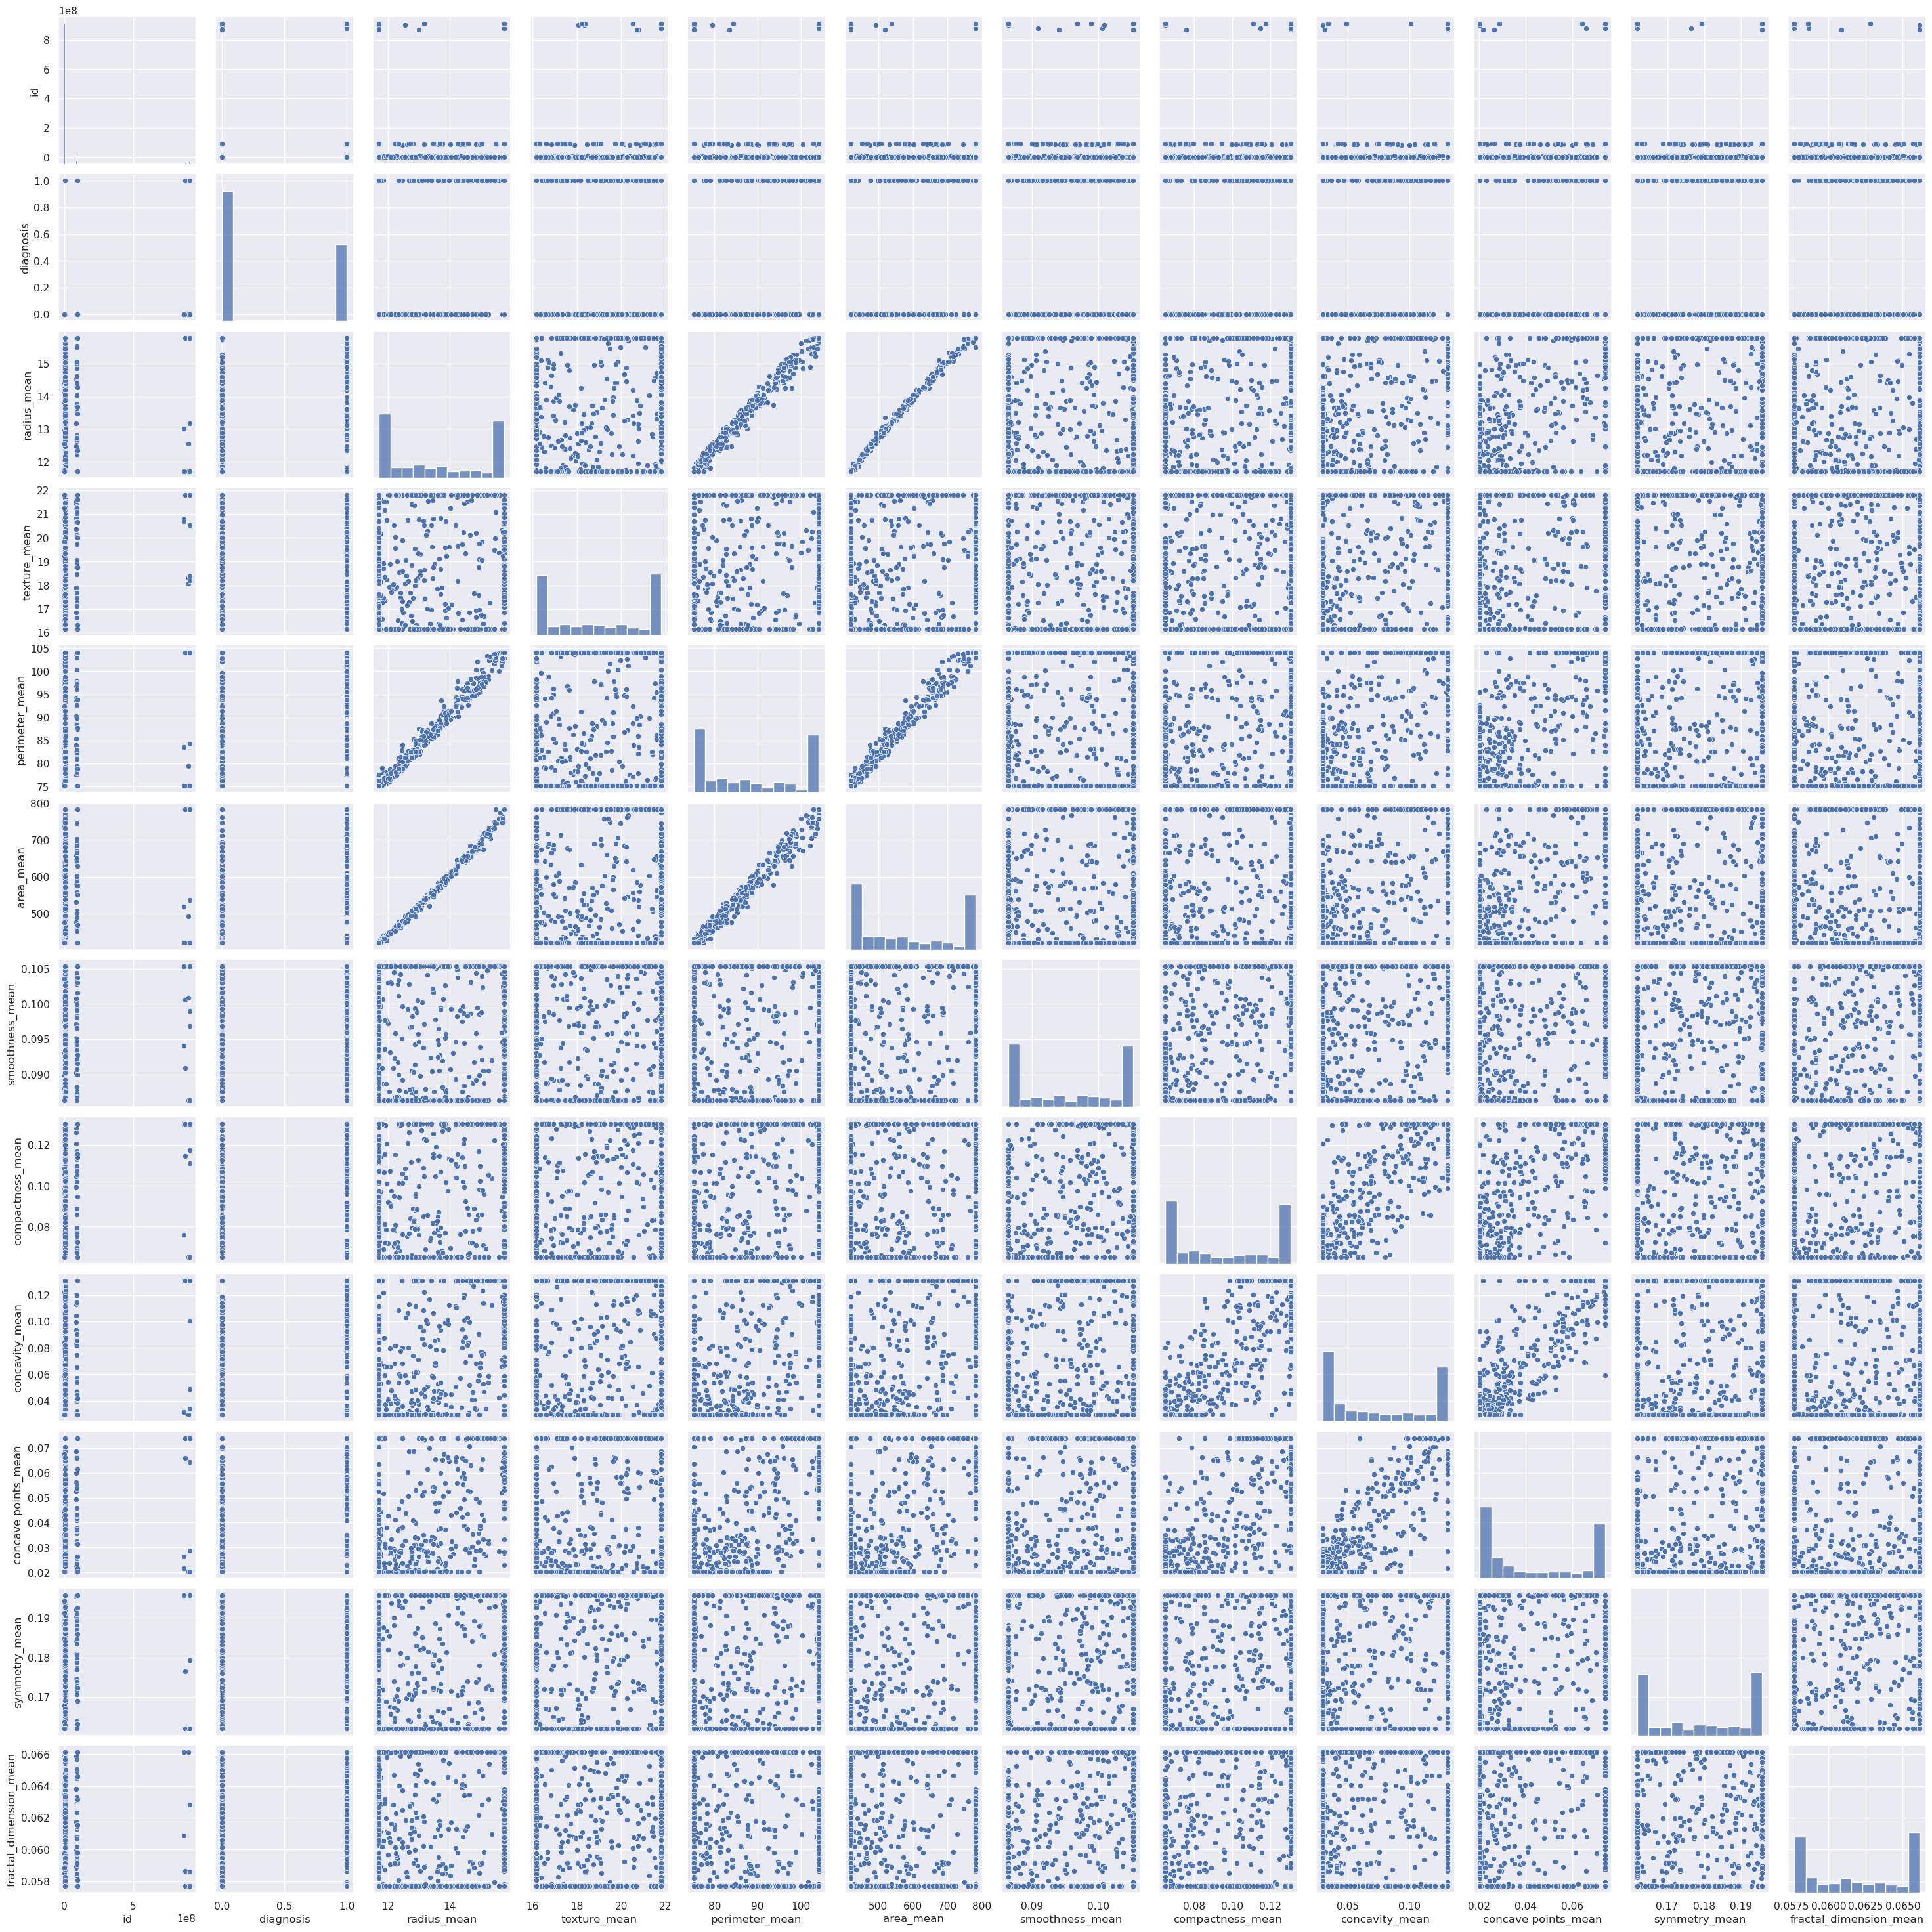

In [12]:
sns.pairplot(cancer)  #pairplot
plt.show()

**What kind of correlation does the data exhibit?**

It doesn't appear that there is any strong correlation within the data, except for features that are linked with each other, such as `perimeter_mean` and `area_mean`. This can be seen both by the scatter plot above but also by the heatmap below.

In [13]:
cancer.corr()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
id,1.000000,0.039769,0.041181,0.095008,0.040604,0.045104,0.004271,0.017424,0.048938,0.026766,-0.032224,-0.077823
diagnosis,0.039769,1.000000,0.753626,0.477759,0.778136,0.767915,0.353435,0.607528,0.776195,0.829890,0.310545,-0.007526
radius_mean,0.041181,0.753626,1.000000,0.343641,0.996419,0.997833,0.155378,0.500481,0.660362,0.759134,0.141260,-0.274135
texture_mean,0.095008,0.477759,0.343641,1.000000,0.358542,0.353827,0.040119,0.278637,0.377615,0.351452,0.113109,-0.034176
perimeter_mean,0.040604,0.778136,0.996419,0.358542,1.000000,0.995279,0.193005,0.548127,0.702009,0.794802,0.176556,-0.226419
area_mean,0.045104,0.767915,0.997833,0.353827,0.995279,1.000000,0.155858,0.500097,0.668059,0.764918,0.147338,-0.275155
smoothness_mean,0.004271,0.353435,0.155378,0.040119,0.193005,0.155858,1.000000,0.623023,0.473384,0.516628,0.501938,0.568905
compactness_mean,0.017424,0.607528,0.500481,0.278637,0.548127,0.500097,0.623023,1.000000,0.877010,0.810419,0.510398,0.455210
concavity_mean,0.048938,0.776195,0.660362,0.377615,0.702009,0.668059,0.473384,0.877010,1.000000,0.919754,0.431175,0.231356
concave points_mean,0.026766,0.829890,0.759134,0.351452,0.794802,0.764918,0.516628,0.810419,0.919754,1.000000,0.424747,0.132415


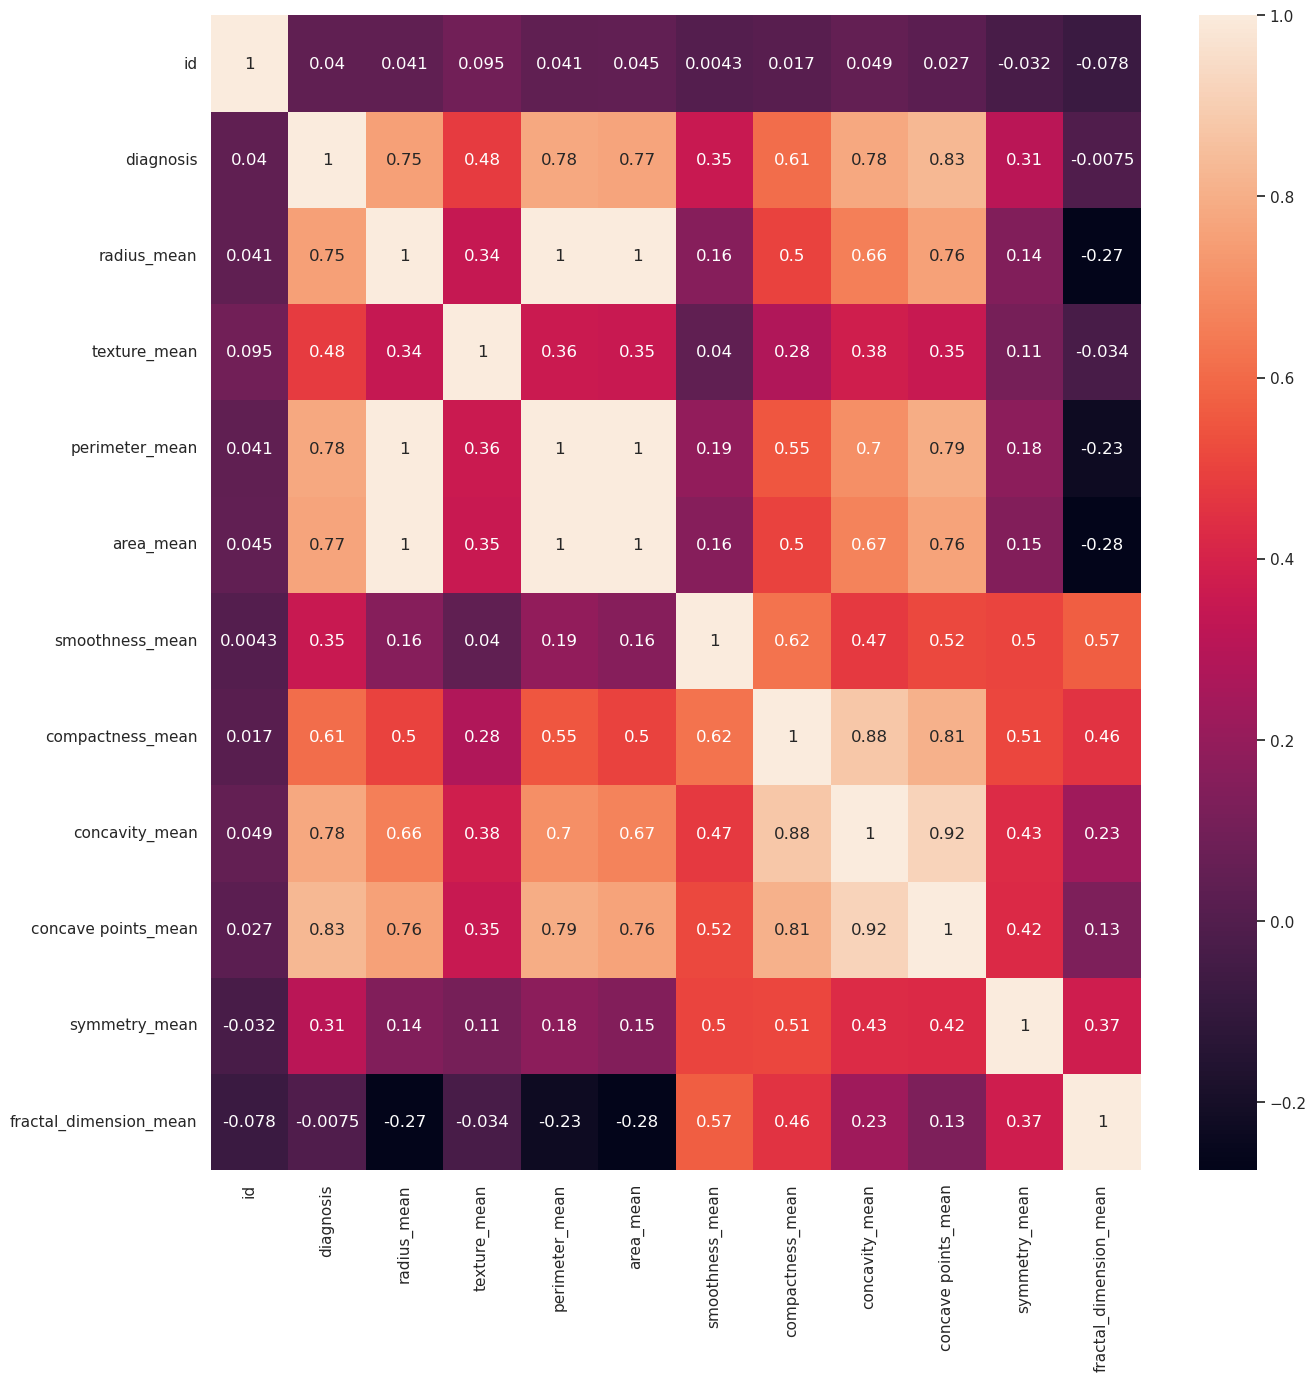

In [14]:
plt.figure(figsize=(15, 15))
sns.heatmap(cancer.corr(), annot = True)
plt.show()

# Steps to build ML model in sklean

## Arrange the data into featues and target arrays.

Based on our `plot_decision_regions` function defined above, we can only use two features for our model. While we do have more, by only using two, we can plot the decision region to see how well our model is performing from a visual perspective.

I'm going to choose the two variables `compactness_mean` and `concavity_mean`, since the seem to be correlated with each other but are two independent variables (whereas `perimeter_mean` and `area_mean` are not since you can calculate one from the other).

In [15]:
# 1. Arrange the data into featues and target arrays.

In [16]:
# extract compactness_mean (7) and concavity_mean (8)
X = cancer.iloc[:, [7, 8]].values
y = cancer.iloc[:, 1]

# print(X)
print(y)

# print(df.columns)

0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: diagnosis, Length: 569, dtype: int64


In [17]:
# extract petal length and petal width
# X = iris.iloc[:,[0, 1]]
# y = iris.iloc[:,4]
# X = iris.iloc[:, :-1]
# y = iris.iloc[:, -1]

print(X.shape)
print(y.shape)

(569, 2)
(569,)


In [18]:
# 2. Split data into a training set and test set
#    Splitting data into 70% training and 30% test data:

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

In [20]:
print('Labels count in y:', np.bincount(y))
print('Labels count in y_train:', np.bincount(y_train))
print('Labels count in y_test:', np.bincount(y_test))

print(X_train.shape)
print(X_test.shape)
# print(X_train)

Labels count in y: [357 212]
Labels count in y_train: [250 148]
Labels count in y_test: [107  64]
(398, 2)
(171, 2)


In [21]:
# 3. Select the ML algorithm, and its parameteters

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

#scaler = StandardScaler()

#X_train_std = scaler.fit_transform(X_train)

#X_test_std = scaler.transform(X_test)


scaler= Normalizer().fit(X_train) # the scaler is fitted to the training set
X_train_normal= scaler.transform(X_train) # the scaler is applied to the training set
X_test_normal = scaler.transform(X_test) # the scaler is applied to the test set

In [23]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, 
                           p=2, 
                           metric='minkowski')

#knn=KNeighborsClassifier(3)
#knn.fit(X_train_normal, y_train)
#y_pred_sklearn= knn.predict(X_test)
#print(y_pred_sklearn)

In [24]:
# 4. Build the model (.fit)

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train)

X_test_std = scaler.transform(X_test)


scaler= Normalizer().fit(X_train) # the scaler is fitted to the training set
X_train_normal= scaler.transform(X_train) # the scaler is applied to the training set
X_test_normal = scaler.transform(X_test) # the scaler is applied to the test set

# print(X_test_normal)

/tmp/ipykernel_435/2412832179.py:28: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],
/tmp/ipykernel_435/2412832179.py:42: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(matplotlib.__version__) < LooseVersion('0.3.4'):


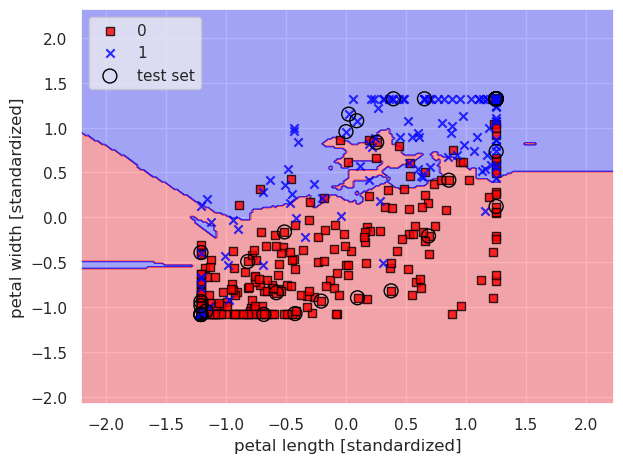

In [26]:
knn.fit(X_train_std, y_train)

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=knn, test_idx=range(105, 150))

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_24.png', dpi=300)
plt.show()

In [27]:
# 5. Apply the model to the test data (.predict)
# 6. Estimate performance (accuracy score)

In [28]:
from sklearn import metrics 
y_pred = knn.predict(X_test_std)
print(metrics.accuracy_score(y_test, y_pred))

0.8713450292397661


## Questions

### What is the maximum accuracy you can achieve with the least amount of features?

The two features I selected are the highest-correlated independent features, so roughly 87% accuracy is what I would expect the highest accuracy to be with two **independent** features.

### How does $k$ affect accuracy?

I tried training with a few different values of $k$ (see below) and found that increasing the value of $k$ increased model accuracy up to a point, then the accuracy started decreasing. This leads me to believe that there is some optimal value of $k$ for this model that could be found via iterative methods like hyperparemeter tuning or similar approaches.

In [29]:
# Try k=3
X = cancer.iloc[:, [7, 8]].values
y = cancer.iloc[:, 1]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

knn = KNeighborsClassifier(n_neighbors=3, 
                           p=2, 
                           metric='minkowski')

scaler= Normalizer().fit(X_train) # the scaler is fitted to the training set
X_train_normal= scaler.transform(X_train) # the scaler is applied to the training set
X_test_normal = scaler.transform(X_test) # the scaler is applied to the test set

knn.fit(X_train_std, y_train)

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

y_pred = knn.predict(X_test_std)
print(metrics.accuracy_score(y_test, y_pred))

0.8654970760233918


In [30]:
# Try k=5
X = cancer.iloc[:, [7, 8]].values
y = cancer.iloc[:, 1]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

knn = KNeighborsClassifier(n_neighbors=5, 
                           p=2, 
                           metric='minkowski')

scaler= Normalizer().fit(X_train) # the scaler is fitted to the training set
X_train_normal= scaler.transform(X_train) # the scaler is applied to the training set
X_test_normal = scaler.transform(X_test) # the scaler is applied to the test set

knn.fit(X_train_std, y_train)

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

y_pred = knn.predict(X_test_std)
print(metrics.accuracy_score(y_test, y_pred))

0.8713450292397661


In [31]:
# Try k=10
X = cancer.iloc[:, [7, 8]].values
y = cancer.iloc[:, 1]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

knn = KNeighborsClassifier(n_neighbors=10, 
                           p=2, 
                           metric='minkowski')

scaler= Normalizer().fit(X_train) # the scaler is fitted to the training set
X_train_normal= scaler.transform(X_train) # the scaler is applied to the training set
X_test_normal = scaler.transform(X_test) # the scaler is applied to the test set

knn.fit(X_train_std, y_train)

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

y_pred = knn.predict(X_test_std)
print(metrics.accuracy_score(y_test, y_pred))

0.8596491228070176


In [32]:
# Try k=1
X = cancer.iloc[:, [7, 8]].values
y = cancer.iloc[:, 1]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

knn = KNeighborsClassifier(n_neighbors=1, 
                           p=2, 
                           metric='minkowski')

scaler= Normalizer().fit(X_train) # the scaler is fitted to the training set
X_train_normal= scaler.transform(X_train) # the scaler is applied to the training set
X_test_normal = scaler.transform(X_test) # the scaler is applied to the test set

knn.fit(X_train_std, y_train)

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

y_pred = knn.predict(X_test_std)
print(metrics.accuracy_score(y_test, y_pred))

0.8187134502923976


In [33]:
# Try k=100
X = cancer.iloc[:, [7, 8]].values
y = cancer.iloc[:, 1]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

knn = KNeighborsClassifier(n_neighbors=100, 
                           p=2, 
                           metric='minkowski')

scaler= Normalizer().fit(X_train) # the scaler is fitted to the training set
X_train_normal= scaler.transform(X_train) # the scaler is applied to the training set
X_test_normal = scaler.transform(X_test) # the scaler is applied to the test set

knn.fit(X_train_std, y_train)

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

y_pred = knn.predict(X_test_std)
print(metrics.accuracy_score(y_test, y_pred))

0.8362573099415205
